# 全体実装

## 入力状態作成

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time 

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.tools.visualization import plot_histogram
import json
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

In [5]:
#visualizes sudoku matrix. Element 0 means empty cell.
def draw_matrix(template):
    empty = np.ones((len(template), len(template)), dtype = np.int32)
    plt.figure()
    plt.axis('off')
    plt.imshow(empty,interpolation='nearest',vmin=1,vmax=4, cmap = "gray_r")
    ys, xs = np.meshgrid(range(template.shape[0]),range(template.shape[1]),indexing='ij')
    for (x,y,val) in zip(xs.flatten(), ys.flatten(), template.flatten()):
        if val == 0:
            plt.text(x,y,None, horizontalalignment='center',verticalalignment='center',)
        else:
            plt.text(x,y,'{0:.0f}'.format(val), horizontalalignment='center',verticalalignment='center',)
    plt.show()

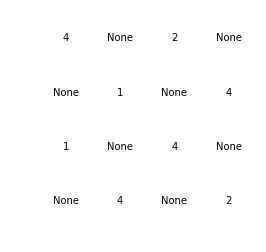

In [6]:
draw_matrix(template)

## 初期状態作成

In [7]:
#Input: sudoku matrix, output: list of qubit numbers assigned to each empty cell and
#the list of numbers in the same row, column and qubicle of each empty cell
def nums(template):
    rows = template.shape[0]
    columns = template.shape[1]
    flat = template.reshape(1, rows**2)[0]
    empty_indices = np.array([np.array([k//4,k%4]) for k in range(rows*columns) if flat[k] == 0])
    q_nums = np.array([[k, k+1] for k in range(0, len(empty_indices)*2, 2)])
    num = []
    for k,index in zip(range(len(empty_indices)),empty_indices):
        row = template[index[0]][:]
        column = np.array([template[k][index[1]] for k in range(rows)])
        #if the empty cell belongs to the upper left box
        if index[0] <= 1 and index[1] <= 1:
            box = np.array([template[i[0]][i[1]] for i in [[0,0],[0,1],[1,0],[1,1]]])
        #if the empty cell belongs to the upper right box
        elif index[0] <= 1 and index[1] > 1:
            box = np.array([template[i[0]][i[1]] for i in [[0,2],[0,3],[1,2],[1,3]]])
        #if the empty cell belongs to the lower left box
        elif index[0] > 1 and index[1] <= 1:
            box = np.array([template[i[0]][i[1]] for i in [[2,0],[2,1],[3,0],[3,1]]])
        #if the empty cell belongs to the lower right box
        elif index[0] > 1 and index[1] > 1:
            box =  np.array([template[i[0]][i[1]] for i in [[2,2],[2,3],[3,2],[3,3]]])
        num.append(np.array([row, column, box]).reshape(1, 12)[0])
    return empty_indices, np.array(num)

print(nums(template))

(array([[0, 1],
       [0, 3],
       [1, 0],
       [1, 2],
       [2, 1],
       [2, 3],
       [3, 0],
       [3, 2]]), array([[4, 0, 2, 0, 0, 1, 0, 4, 4, 0, 0, 1],
       [4, 0, 2, 0, 0, 4, 0, 2, 2, 0, 0, 4],
       [0, 1, 0, 4, 4, 0, 1, 0, 4, 0, 0, 1],
       [0, 1, 0, 4, 2, 0, 4, 0, 2, 0, 0, 4],
       [1, 0, 4, 0, 0, 1, 0, 4, 1, 0, 0, 4],
       [1, 0, 4, 0, 0, 4, 0, 2, 4, 0, 0, 2],
       [0, 4, 0, 2, 4, 0, 1, 0, 1, 0, 0, 4],
       [0, 4, 0, 2, 2, 0, 4, 0, 4, 0, 0, 2]]))


In [8]:
#Input: sudoku matrix,
#Output: list of elements in the same row, column and box of the empty cell in question.
def candidates(template, nums):
    sudoku_size = template.shape[0]
    all_cands = np.arange(1, sudoku_size + 1)
    counts = np.array([np.count_nonzero(nums == all_cands[k]) for k in range(len(all_cands))])
    cand_indices = np.where(counts==0)[0]
    cands = np.array([all_cands[k] for k in cand_indices])
    return set(cands)

# print(candidates(template, [4, 0, 2, 0, 0, 4, 0, 2, 2, 0, 0, 4]))

In [9]:
def single_cand_operation(qc, q0, q1, cands):
    if cands == {1}:
        pass
    elif cands == {2}:
        qc.x(q1)
    elif cands == {3}:
        qc.x(q0)
    else:
        qc.x(q0)
        qc.x(q1)
        
def single_cand_operation_inv(qc, q0, q1, cands): 
    '''identical as noinv'''
    if cands == {1}:
        pass
    elif cands == {2}:
        qc.x(q1)
    elif cands == {3}:
        qc.x(q0)
    else:
        qc.x(q1)
        qc.x(q0)

def two_cand_operation(qc, q0, q1, cands):
#     product = cands[0]*cands[1]
    #1 + 2
    if cands == {1, 2}:
        qc.h(q1)
    #1 + 3
    elif cands == {1, 3}:
        qc.h(q0)
    #1 + 4
    elif cands == {1, 4}:
        qc.h(q0)
        qc.cx(q0, q1)
    #2 + 3
    elif cands == {2, 3}:
        qc.x(q1)
        qc.h(q0)
        qc.cx(q0, q1)
    #2 + 4
    elif cands == {2, 4}:
        qc.x(q1)
        qc.h(q0)
    #3 + 4
    else:
        qc.h(q1)
        qc.x(q0)
    
def two_cand_operation_inv(qc, q0, q1, cands):
#     product = cands[0]*cands[1]
    #1 + 2
    if cands == {1, 2}:
        qc.h(q1)
    #1 + 3
    elif cands == {1, 3}:
        qc.h(q0)
    #1 + 4
    elif cands == {1, 4}:
        qc.cx(q0, q1)
        qc.h(q0)
    #2 + 3
    elif cands == {2, 3}:
        qc.cx(q0, q1)
        qc.h(q0)
        qc.x(q1)
    #2 + 4
    elif cands == {2, 4}:
        qc.h(q0)
        qc.x(q1)
    #3 + 4
    else:
        qc.h(q1)
        qc.x(q0)

In [15]:
def create_initial(qc, q, template):
    # q: only qubits on blanks (ancillae not included)
#     draw_matrix(template)
    empty_indices, num = nums(template)
    cands_list = np.array([candidates(template, num[k]) for k in range(len(num))])
    for j,k in zip(range(0, len(empty_indices)*2, 2),range(len(cands_list))):
        cands = cands_list[k]
        if len(cands) == 1:
            single_cand_operation(qc, q[j], q[j+1], cands)
        else:
            two_cand_operation(qc, q[j], q[j+1], cands)
            
def create_initial_inv(qc, q, template):
    empty_indices, num = nums(template)
    cands_list = np.array([candidates(template, num[k]) for k in range(len(num))])
    for j,k in zip(range(0, len(empty_indices)*2, 2),range(len(cands_list))):
        cands = cands_list[k]
        if len(cands) == 1:
            single_cand_operation_inv(qc, q[j], q[j+1], cands)
        else:
            two_cand_operation_inv(qc, q[j], q[j+1], cands)

In [11]:
# oracle

# if v1 != v2 (number) then target = 1 else target = 0
def compare_vertex(qc, qr, v1, v2, target):
    qc.x(qr[2*v2])
    qc.x(qr[2*v2+1])
    qc.ccx(qr[2*v1], qr[2*v1+1], target)
    qc.ccx(qr[2*v1+1], qr[2*v2], target)
    qc.ccx(qr[2*v2], qr[2*v2+1], target)
    qc.ccx(qr[2*v1], qr[2*v2+1], target)
    qc.x(qr[2*v2+1])
    qc.x(qr[2*v2])
    #
    qc.x(qr[target])

def compare_vertex_inv(qc, qr, v1, v2, target):
    qc.x(qr[target])
    #
    qc.x(qr[2*v2])
    qc.x(qr[2*v2+1])
    qc.ccx(qr[2*v1], qr[2*v2+1], target)
    qc.ccx(qr[2*v2], qr[2*v2+1], target)
    qc.ccx(qr[2*v1+1], qr[2*v2], target)
    qc.ccx(qr[2*v1], qr[2*v1+1], target)
    qc.x(qr[2*v2+1])
    qc.x(qr[2*v2])

# とりあえず辺埋め込みオラクル
def simple_oracle(qc, qr):
    # vs = [0, 1, 2, 3, 4, 5, 6, 7]
    lst = [[0, 1], [2, 3], [4, 5], [6, 7], [2, 6], [0, 4], [1, 5], [3, 7], [0, 2], [1, 3], [4, 6], [5, 7]]
    target = 16
    for elm in lst:
        assert(len(elm)==2)
        compare_vertex(qc, qr, elm[0], elm[1], target)
        target+=1
    assert(target<=29)
    dst = 29
    qc.mct(qr[16:target], qr[dst], [], mode='noancilla')
    for elm in (reversed(lst)):
        target-=1
        compare_vertex_inv(qc, qr, elm[0], elm[1], target)


In [12]:
# diffusion

def diffusion(circuit, qr, template):
    """
    diffusion (inversion about the mean) circuit.
    note that this implementation gives H^{\otimes n} (Id - |0..0><0...0|) H^{\otimes n}
    :param circuit:
    :param qr: QuantumRegister on blanks (ancillae not included)
    :return:
    """

    # circuit.h(qr)
    create_initial_inv(circuit, qr, template)  # 初期状態準備のユニタリ操作のinverse
    circuit.x(qr)

    # apply multi-control CZ
    circuit.h(qr[-1])
    # circuit.mct(qr[:-1], qr[-1], anc, mode='basic')
    circuit.mct(qr[:-1], qr[-1], [], mode='noancilla')  # ancilla使わないver
    circuit.h(qr[-1])

    circuit.x(qr)
    # circuit.h(qr)
    create_initial(circuit, qr, template)

In [13]:
def grover(circuit, q, c, template):

    # set initial state
    create_initial(circuit, q[:16], template)
    
    for _ in range(n_it):
        simple_oracle(circuit, q)
        diffusion(circuit, q[:16], template)
    
    # measurement
    circuit.measure(q[:n_cbits],c)

In [16]:
# number of iteration
n_it = 1

In [17]:
# 初期状態
template = \
    np.array([[4, 0, 2, 0],
              [0, 1, 0, 4],
              [1, 0, 4, 0],
              [0, 4, 0, 2]])

In [18]:
# circuit construction 
n_qubits = 32
n_blanks = 8
n_cbits = 2 * n_blanks

q = QuantumRegister(n_qubits) 
c = ClassicalRegister(n_cbits)
circuit = QuantumCircuit(q, c)

In [19]:
grover(circuit, q, c, template)

In [ ]:
# circuit.draw(output='mpl')
circuit.draw()

In [31]:
### Execution
time0 = time.time()
# shots = 8000
shots = 100
print("shots:", shots)

## local simulator
backend = Aer.get_backend('qasm_simulator')
## cloud simulator
# provider = IBMQ.load_account()
# backend = provider.get_backend('ibmq_qasm_simulator')

job = execute(circuit, backend=backend, shots=shots, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count = result.get_counts()
time1 = time.time()
print(f"Calculations took {time1-time0} sec.")
print(count)

No measurements in circuit "circuit0": count data will return all zeros.


shots: 100
Calculations took 0.051225900650024414 sec.
{'0000000000000000': 100}


In [161]:
# サンプリング結果の最頻値
most_frequent = sorted(count.items(), key=lambda x:x[1], reverse=True)[0][0]

In [29]:
# 10進数(1~4)に変換
def convert_to_decimal(str_bin):
    str_bin = ''.join(list(reversed(str_bin)))  # cbitに格納されるときに順番逆になっていることに注意
    list_dec = [int(str_bin[2*i:2*i+2], 2)+1 for i in range(len(str_bin)//2)]
    return list_dec

In [164]:
solution = convert_to_decimal(most_frequent)
print(solution)

[4, 1, 1, 1, 1, 1, 1, 1]


### validation


In [56]:
template_answer_filled = template.copy()

# 回答で埋める
k = 0
for i in range(4):
    for j in range(4):
        if template_answer_filled[i][j] == 0:
            template_answer_filled[i][j] = solution[k]
            k += 1
            
template_answer_filled = np.array(template_answer_filled)

In [57]:
template_answer_filled

array([[4, 1, 2, 1],
       [1, 1, 1, 4],
       [1, 1, 4, 1],
       [1, 4, 1, 2]])